In [94]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

%matplotlib inline

In [95]:
wiki_data = pd.read_pickle('wiki_data.p')

In [3]:
wiki_data.sample(10)

,_id,category,content,pageid,title,clean_content
5385,5920729fad28cdd96d850916,Yoga,Swami Pranavananda (Bengali: স্বামী প্রণবানন্দ...,32972442,Pranavananda,swami pranavananda bengali বরণব নন also known ...
2664,591c96cead28cdd96d818f3d,Petroleum,Ploiești (Romanian pronunciation: [ploˈjeʃtʲ];...,327584,Ploiești,ploiești romanian pronunciationploˈjeʃtʲolder ...
685,591bad45ad28cdd96d8152a1,machine learning,"ND4S is a free, open-source extension of the S...",47459238,ND4S,nds is a free open source extension of the sca...
948,591bafb9ad28cdd96d8155af,machine learning,"Stephen H. Muggleton FBCS, FIET, FAAAI,FECCAI,...",7895245,Stephen Muggleton,stephen muggleton fbcs fiet faaai feccai fsb f...
2267,591c95bdad28cdd96d818bb0,Petroleum,"James Edwin Darnell Jr. (born September 9, 193...",7025943,James E. Darnell,james edwin darnell jrborn september columbus ...
2500,591c9661ad28cdd96d818dca,Petroleum,"Meile Louise Rockefeller (born December 5, 195...",2886582,Meile Rockefeller,meile louise rockefeller born december in broo...
3153,591c98aaad28cdd96d8193ed,Yoga,Uttanasana (/uːtəˈnɑːsənɑː/ OO-tə-NAH-sə-nah) ...,2606604,Uttanasana,uttanasanauːtəˈnɑːsənɑː oo tə nah sə nahsanskr...
2000,591c950cad28cdd96d818957,Petroleum,Deloitte Touche Tohmatsu Limited /dəˈlɔɪt ˈtuː...,586015,Deloitte,deloitte touche tohmatsu limited dəˈlɔɪt ˈtuːʃ...
4476,592004c6ad28cdd96d84e7ef,Taiwan,The Chevaliers is a 1994 Taiwanese television ...,51322685,The Chevaliers,the chevaliers is a taiwanese television drama...
3201,591c9c78ad28cdd96d81958f,Business intelligence,Agency.com was an interactive marketing agency...,4209890,Agency.com,agency com was an interactive marketing agency...


### vectorize text: (reduce number of features by setting min_df = 5)

In [96]:
tfidf_vectorizer = TfidfVectorizer(min_df = 5, stop_words = 'english')
document_term_matrix = tfidf_vectorizer.fit_transform(wiki_data['content'])

In [97]:
document_term_matrix.shape

(5665, 27356)

### perform LSA on text using SVD:

In [98]:
SVD = TruncatedSVD(n_components=400)
latent_semantic_analysis = SVD.fit_transform(document_term_matrix)

In [99]:
np.save('LSA', latent_semantic_analysis)

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


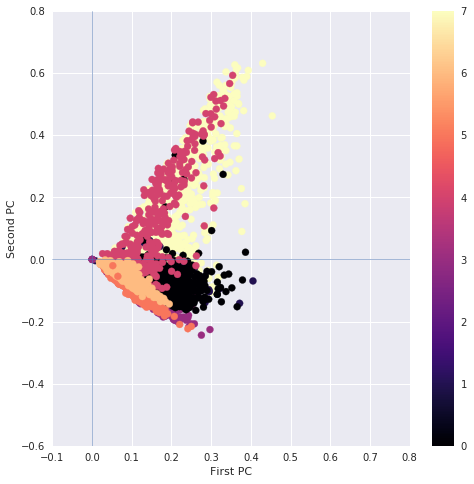

In [22]:
# from before, deleted source for LSA_df

plt.figure(figsize=(8,8))
pc_1 = LSA_df['component_1'].values
pc_2 = LSA_df['component_2'].values

plt.scatter(pc_1, pc_2, c=wiki_data['category'], cmap='magma')

plt.xlabel('First PC')
plt.ylabel('Second PC')
plt.axvline(linewidth=0.5)
plt.axhline(linewidth=0.5)
plt.xlim(-.1,.8)
plt.ylim(-.6,.8)
plt.colorbar()

### type in any search term:

In [101]:
search_term = "machine learning"

### vectorize the search term using same transformer that was fit on pages content:

In [102]:
search_term_vec = tfidf_vectorizer.transform([search_term])
search_term_lsa = SVD.transform(search_term_vec)

### get top five cosine similarities for search term:

In [103]:
cos_sim = cosine_similarity(search_term_lsa, latent_semantic_analysis)

In [104]:
cos_sim[0].argsort()[:-6:-1]

array([748, 604, 461, 786,  18])

In [105]:
top_five_scores = cos_sim[0].argsort()[:-6:-1]

In [106]:
print(top_five_scores)

[748 604 461 786  18]


In [109]:
top_five_df = wiki_data.iloc[top_five_scores]

In [120]:
top_five_df[['category', 'pageid', 'title','clean_content']]

,category,pageid,title,clean_content
748,7,53587467,Outline of machine learning,the following outline is provided as an overvi...
604,7,233488,Machine learning,machine learning is the subfield of computer s...
461,7,33762888,Inferential theory of learning,inferential theory of learning itl is an area ...
786,7,44942962,Portal:Machine learning/Selected biography,selected persons biography archive for the mac...
18,7,45049676,Adversarial machine learning,adversarial machine learning is a research fie...


### use NearestNeighbors to get top five neighbors for search term:

In [111]:
titles_vec = tfidf_vectorizer.transform(wiki_data['title'])
titles_lsa = SVD.transform(titles_vec)

In [112]:
from sklearn.neighbors import NearestNeighbors

In [113]:
nn = NearestNeighbors()

In [115]:
nn.fit(titles_lsa)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [118]:
def most_similar(search):
    distances, indices = nn.kneighbors(search)
    return wiki_data.ix[indices[0]][['category', 'pageid', 'title','clean_content']]

In [119]:
most_similar(search_term_lsa)

,category,pageid,title,clean_content
988,7,39478785,Tanagra (machine learning),tanagra is a free suite of machine learning so...
604,7,233488,Machine learning,machine learning is the subfield of computer s...
10,7,28801798,Active learning (machine learning),active learning is a special case of semi supe...
1005,7,50828755,Timeline of machine learning,this page is a timeline of machine learning ma...
748,7,53587467,Outline of machine learning,the following outline is provided as an overvi...


### Use the dot product approximation to get top five neighbors for search term:

In [79]:
cosine_similarities = latent_semantic_analysis.dot(search_term_lsa.T).ravel()

In [80]:
top_neighbors = cosine_similarities.argsort()[:-6:-1]

In [82]:
top_neighbors_df = wiki_data.iloc[top_neighbors]

In [121]:
top_neighbors_df[['category', 'pageid', 'title','clean_content']]

,category,pageid,title,clean_content
737,7,19892153,Online machine learning,in computer science online machine learning is...
275,7,1455062,Empirical risk minimization,empirical risk minimization erm is a principle...
975,7,20926,Supervised learning,supervised learning is the machine learning ta...
678,7,52242050,Multiplicative Weight Update Method,multiplicative weight update method is a meta ...
283,7,48833041,Error Tolerance (PAC learning),error tolerance pac learning in pac learning ...
